In [1]:
import os
import math
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader,random_split
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn import Transformer
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import warnings
warnings.filterwarnings('ignore')
wandb.login()

wandb: Currently logged in as: dwkim8155. Use `wandb login --relogin` to force relogin


True

# EDA

## 공주지역

### PM 분포

PM_왜도: 2.29719388281209
PM_첨도: 9.973496844637072


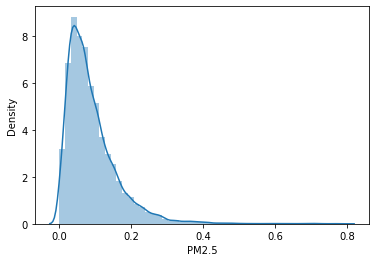

In [75]:
df_공주 = pd.read_csv('/opt/ml/data/TRAIN/공주.csv')
df_aws_공주 = pd.read_csv('/opt/ml/data/TRAIN_AWS/공주.csv')

sns.distplot(df_공주['PM2.5'])
print('PM_왜도: {}'.format(df_공주['PM2.5'].skew()))
print('PM_첨도: {}'.format(df_공주['PM2.5'].kurtosis()))

### 기온 분포

기온_왜도: -0.18290468803721474
기온_첨도: -0.8987470552057557


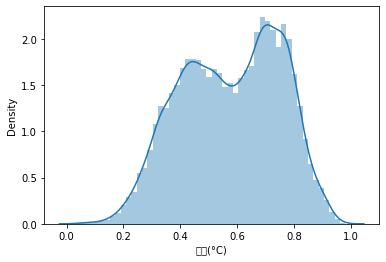

In [80]:
sns.distplot(df_aws_공주['기온(°C)'])
print('기온_왜도: {}'.format(df_aws_공주['기온(°C)'].skew()))
print('기온_첨도: {}'.format(df_aws_공주['기온(°C)'].kurtosis()))

### 풍향 분포

풍향_왜도: 0.37363438626135553
풍향_첨도: -1.4711895360523195


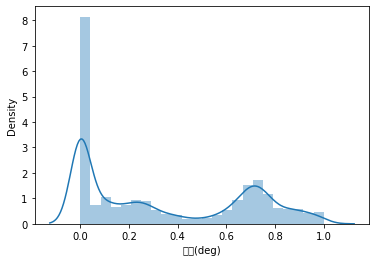

In [81]:
sns.distplot(df_aws_공주['풍향(deg)'])
print('풍향_왜도: {}'.format(df_aws_공주['풍향(deg)'].skew()))
print('풍향_첨도: {}'.format(df_aws_공주['풍향(deg)'].kurtosis()))

### 풍속 분포

풍속_왜도: 1.2281327894225371
풍속_첨도: 1.848898051568542


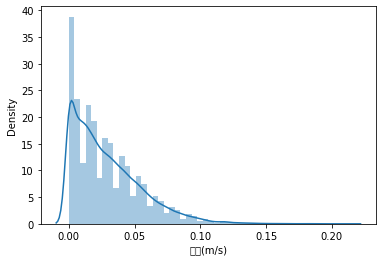

In [84]:
sns.distplot(df_aws_공주['풍속(m/s)'])
print('풍속_왜도: {}'.format(df_aws_공주['풍속(m/s)'].skew()))
print('풍속_첨도: {}'.format(df_aws_공주['풍속(m/s)'].kurtosis()))

### 강수량 분포

강수량_왜도: 17.53746250951375
강수량_첨도: 552.0305520014417


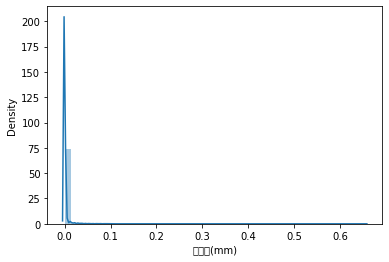

In [86]:
sns.distplot(df_aws_공주['강수량(mm)'])
print('강수량_왜도: {}'.format(df_aws_공주['강수량(mm)'].skew()))
print('강수량_첨도: {}'.format(df_aws_공주['강수량(mm)'].kurtosis()))

### 습도 분포

습도_왜도: -0.5556925897971579
습도_첨도: -0.7496544533276639


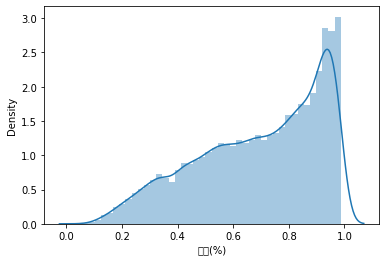

In [87]:
sns.distplot(df_aws_공주['습도(%)'])
print('습도_왜도: {}'.format(df_aws_공주['습도(%)'].skew()))
print('습도_첨도: {}'.format(df_aws_공주['습도(%)'].kurtosis()))

In [85]:
#통계 수치 확인
df_cat = pd.concat([df_공주,df_aws_공주.iloc[:,3:]], axis=1)
df_cat.describe()

,연도,PM2.5,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
count,35064.000000,34294.000000,34380.000000,34380.000000,34380.000000,34380.000000,34380.000000
mean,1.501027,0.089519,0.578108,0.346713,0.028784,0.001627,0.694966
std,1.118356,0.072571,0.175015,0.337584,0.025935,0.011652,0.222819
min,0.000000,0.000000,0.039494,0.000000,0.000000,0.000000,0.058000
25%,1.000000,0.040000,0.436019,0.000000,0.007673,0.000000,0.529000
50%,2.000000,0.072000,0.589258,0.236528,0.023018,0.000000,0.737000
75%,3.000000,0.116000,0.723539,0.698333,0.043478,0.000000,0.894000
max,3.000000,0.792000,0.981043,1.000000,0.212276,0.653409,0.987000


In [4]:
#결측치 파악
df_cat.isna().sum()

연도           0
일시           0
측정소          0
PM2.5      770
기온(°C)     684
풍향(deg)    684
풍속(m/s)    684
강수량(mm)    684
습도(%)      684
dtype: int64

## 통합 데이터 구축

In [5]:
#aws-pm data 매칭 -> 거리 기준

meta_df_pm = pd.read_csv('/opt/ml/data/META/pmmap.csv')
pm_loca_data = meta_df_pm.iloc[:,:3].to_numpy()

meta_df_aws = pd.read_csv('/opt/ml/data/META/awsmap.csv')
aws_loca_data = meta_df_aws.iloc[:,:3].to_numpy()

aws_match_list = []

for pm in pm_loca_data:
    pm_loca, pm_la, pm_lo = pm
    
    min_norm = float('inf')
    min_loca = ''
    for aws in aws_loca_data:
        aws_loca, aws_la, aws_lo = aws
        val = np.array([pm_la - aws_la, pm_lo - aws_lo])
        no = np.linalg.norm(val)
        if min_norm > no:
            min_norm = no
            min_loca = aws_loca
    
    aws_match_list.append((pm_loca, min_loca))

#pm-aws matching dict형태
aws_match_dict = dict()
for pm, aws in aws_match_list:
    aws_match_dict[pm] = aws

data_dict = {}    
train_path = '/opt/ml/data/TRAIN'
trainaws_path = '/opt/ml/data/TRAIN_AWS/'

def merge_df(pm_loca, aws_loca):
    df_pm_loca = pd.read_csv(os.path.join(train_path, pm_loca+'.csv'))
    df_aws_loca = pd.read_csv(os.path.join(trainaws_path, aws_loca+'.csv')).iloc[:,3:]
    df = pd.concat([df_pm_loca,df_aws_loca],axis=1).iloc[:,3:]
    return df
    
    

for loca in aws_match_list:
    pm_loca, aws_loca = loca
    data_dict[pm_loca] = merge_df(pm_loca, aws_loca)

In [6]:
df_total = pd.concat(list(data_dict.values()),axis=0)
df_total.describe()

,PM2.5,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
count,580546.000000,585790.000000,585790.000000,585790.000000,585790.000000,585790.000000
mean,0.085153,0.581792,0.418020,0.040295,0.001546,0.706114
std,0.071679,0.165542,0.342206,0.035796,0.012335,0.206325
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.036000,0.450237,0.036111,0.012788,0.000000,0.559000
50%,0.068000,0.590837,0.408333,0.033248,0.000000,0.729000
75%,0.112000,0.718799,0.728333,0.058824,0.000000,0.890000
max,1.000000,0.998420,1.000000,0.434783,0.897727,0.988000


In [88]:
#상관관계 분석
df_total.corr()

,PM2.5,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
PM2.5,1.000000,-0.251973,-0.037584,-0.158875,-0.079920,0.039337
기온(°C),-0.251973,1.000000,0.035149,0.086485,0.064555,0.032808
풍향(deg),-0.037584,0.035149,1.000000,0.403602,-0.018477,-0.288281
풍속(m/s),-0.158875,0.086485,0.403602,1.000000,0.047413,-0.304950
강수량(mm),-0.079920,0.064555,-0.018477,0.047413,1.000000,0.144939
습도(%),0.039337,0.032808,-0.288281,-0.304950,0.144939,1.000000


In [7]:
#전체 결측치 파악
df_total.isna().sum()

PM2.5      15542
기온(°C)     10298
풍향(deg)    10298
풍속(m/s)    10298
강수량(mm)    10298
습도(%)      10298
dtype: int64

# Imputation

* aws 관측(기온, 풍향, 풍속 등) 자료들이 PM값과 관련이 높다고 가정하고 이를 바탕으로 PM결측치를 추정하는 모델을 만듦 

## 1. XGBoost 사용

In [8]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score


#dataset 구성, 결측치 drop
df_total = pd.concat(list(data_dict.values()),axis=0).dropna(how='any')
df_total.head()

,PM2.5,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
0,0.044,0.170616,0.053333,0.017903,0.0,0.764
1,0.048,0.167457,0.099444,0.020460,0.0,0.759
2,0.060,0.162717,0.134167,0.012788,0.0,0.760
3,0.064,0.157978,0.000000,0.005115,0.0,0.747
4,0.064,0.148499,0.000000,0.007673,0.0,0.791


In [9]:
X_features = df_total.iloc[:,1:].to_numpy()
y_label = df_total['PM2.5'].to_numpy()

#train,val,test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

#DMatrix형태로 바꿔주기
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test)

#hyperparameters 설정
params = {'max_depth' : 6,
         'eta' : 0.3, 
         'objective' : 'reg:squarederror',
         'eval_metric' : 'mae',
   }

#모델 선언 및 학습
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = 400, 
                        early_stopping_rounds = 100, evals=[(dtrain,'train'),(dval,'eval')])

[0]	train-mae:0.29163	eval-mae:0.29152
[1]	train-mae:0.20649	eval-mae:0.20647
[2]	train-mae:0.14854	eval-mae:0.14859
[3]	train-mae:0.10992	eval-mae:0.11004
[4]	train-mae:0.08489	eval-mae:0.08505
[5]	train-mae:0.06921	eval-mae:0.06940
[6]	train-mae:0.05961	eval-mae:0.05984
[7]	train-mae:0.05390	eval-mae:0.05415
[8]	train-mae:0.05045	eval-mae:0.05071
[9]	train-mae:0.04838	eval-mae:0.04865
[10]	train-mae:0.04710	eval-mae:0.04738
[11]	train-mae:0.04631	eval-mae:0.04661
[12]	train-mae:0.04581	eval-mae:0.04612
[13]	train-mae:0.04546	eval-mae:0.04578
[14]	train-mae:0.04524	eval-mae:0.04556
[15]	train-mae:0.04509	eval-mae:0.04542
[16]	train-mae:0.04495	eval-mae:0.04530
[17]	train-mae:0.04487	eval-mae:0.04522
[18]	train-mae:0.04481	eval-mae:0.04517
[19]	train-mae:0.04476	eval-mae:0.04513
[20]	train-mae:0.04473	eval-mae:0.04511
[21]	train-mae:0.04471	eval-mae:0.04510
[22]	train-mae:0.04469	eval-mae:0.04509
[23]	train-mae:0.04467	eval-mae:0.04507
[24]	train-mae:0.04465	eval-mae:0.04506
[25]	train

In [10]:
#성능 평가
y_pred = xgb_model.predict(dtest)
print('explained_variance_score: {}'.format(explained_variance_score(y_test, y_pred)))
print('mean_squared_errors: {}'.format(mean_squared_error(y_test, y_pred)))
print('r2_score: {}'.format(r2_score(y_test, y_pred)))

explained_variance_score: 0.18599994407953335
mean_squared_errors: 0.004164362284106277
r2_score: 0.1859961863783638


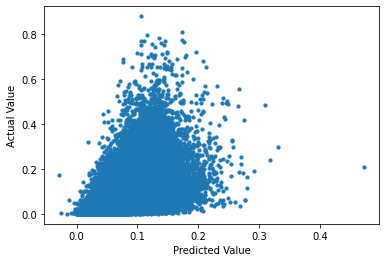

In [11]:
plt.scatter(y_pred, y_test, s=10)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.show()

## 2. MLP 사용

In [12]:
#dataset 설정
class Missing_Value_Dataset(Dataset):
    
    def __init__(self,df):
        self.df = df
        
        self.x = df.iloc[:,1:].to_numpy()
        self.y = df['PM2.5'].to_numpy()
        
        self.x = torch.tensor(self.x, dtype=torch.float)
        self.y = torch.tensor(self.y, dtype=torch.float)
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
                          
    
    def __len__(self):
        return len(self.y)

data_dict = {}    
train_path = '/opt/ml/data/TRAIN'
trainaws_path = '/opt/ml/data/TRAIN_AWS/'

def merge_df(pm_loca, aws_loca):
    df_pm_loca = pd.read_csv(os.path.join(train_path, pm_loca+'.csv'))
    df_aws_loca = pd.read_csv(os.path.join(trainaws_path, aws_loca+'.csv')).iloc[:,3:]
    df = pd.concat([df_pm_loca,df_aws_loca],axis=1).iloc[:,3:].dropna(how='any')
    return df
    
    

for loca in aws_match_list:
    pm_loca, aws_loca = loca
    data_dict[pm_loca] = merge_df(pm_loca, aws_loca)    

df_total = pd.concat(list(data_dict.values()),axis=0)   
batch_size = 256
dataset = Missing_Value_Dataset(df_total)

n_val = 20000
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val])

In [13]:
# 모델 설정
class UPBlock(nn.Module):
    def __init__(self, in_dims):
        super().__init__()
        self.in_dims = in_dims
        
        self.upblock = nn.Sequential(
                      nn.Linear(self.in_dims, self.in_dims*2),
                      nn.BatchNorm1d(self.in_dims*2),
                      nn.Dropout(p=0.1),
                      nn.ReLU()
        )
        
    def forward(self,x):
        return self.upblock(x)

    
class DownBlock(nn.Module):
    def __init__(self, in_dims):
        super().__init__()
        self.in_dims = in_dims
        
        self.downblock = nn.Sequential(
                      nn.Linear(self.in_dims, self.in_dims//2),
                      nn.BatchNorm1d(self.in_dims//2),
                      nn.Dropout(p=0.1),
                      nn.ReLU()
        )
        
    def forward(self,x):
        return self.downblock(x)

    
class MLPModel(nn.Module):
    def __init__(self, in_dims, out_dims):
        super().__init__()
        self.in_dims = in_dims
        self.out_dims = out_dims
        
        self.upblock1 = UPBlock(self.in_dims)
        self.upblock2 = UPBlock(self.in_dims*2)
        self.upblock3 = UPBlock(self.in_dims*4)
        self.upblock4 = UPBlock(self.in_dims*8)
        self.upblock5 = UPBlock(self.in_dims*16)
        
        self.downblock1 = DownBlock(self.in_dims*32)
        self.downblock2 = DownBlock(self.in_dims*16)
        self.downblock3 = DownBlock(self.in_dims*8)
        self.downblock4 = DownBlock(self.in_dims*4)
        self.downblock5 = DownBlock(self.in_dims*2)
        
        self.fc = nn.Linear(self.in_dims, self.out_dims)
        
        self.apply(self.initialize_weights)
        
    def forward(self,x):
        out = self.upblock1(x)
        out = self.upblock2(out)
        out = self.upblock3(out)
        out = self.upblock4(out)
        out = self.upblock5(out)
        
        out = self.downblock1(out)
        out = self.downblock2(out)
        out = self.downblock3(out)
        out = self.downblock4(out)
        out = self.downblock5(out)
        
        out = self.fc(out)
        
        return out
    
    def initialize_weights(self, module):        
        for m in module.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.zero_()

In [14]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=4)
val_loader = DataLoader(val_set, shuffle=False, batch_size=batch_size, num_workers=4)

In [15]:
# Hyperparameters
# lr = 0.00001
device = 'cuda'
# epochs = 30
model = MLPModel(5,1).to(device, non_blocking=True)
# criterion =nn.MSELoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
# model_name = 'MLP_결측치예측모델'

In [ ]:
#미리 학습한 가중치 사용
model.load_state_dict(torch.load('/opt/ml/parameter/MLP_결측치예측모델/Epoch:6-loss:0.005269-mae:12.783139%-best.pt'))

In [18]:
all_predictions = []
for data,y in tqdm(val_loader, leave=False):
    with torch.no_grad():
        data = data.to(device)
        pred = model(data)
        pred = torch.flatten(pred)
    all_predictions.extend(pred.detach().cpu().numpy())
    
predict = np.array(all_predictions)
predict = np.where(predict<0, 0.0, predict)

real = []
for data,y in tqdm(val_loader, leave=False):
    real.extend(y.detach().cpu().numpy())
real = np.array(real)
print('explained_variance_score: {}'.format(explained_variance_score(real, predict)))
print('mean_squared_errors: {}'.format(mean_squared_error(real, predict)))
print('r2_score: {}'.format(r2_score(real, predict)))

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

explained_variance_score: -0.4165581464767456
mean_squared_errors: 0.007486846297979355
r2_score: -0.41658428948429704


* 만든 MLP보다 XGBoost 성능이 더 좋은 관계로 PM 결측치 대치에는 XGBoost 사용

## 3. 결측치 채우기

In [12]:
data_dict = {}    
train_path = '/opt/ml/data/TRAIN'
trainaws_path = '/opt/ml/data/TRAIN_AWS/'

def merge_df(pm_loca, aws_loca):
    df_pm_loca = pd.read_csv(os.path.join(train_path, pm_loca+'.csv'))
    df_aws_loca = pd.read_csv(os.path.join(trainaws_path, aws_loca+'.csv')).iloc[:,3:]
    df = pd.concat([df_pm_loca,df_aws_loca],axis=1).iloc[:,3:]
    return df
    
    

for loca in aws_match_list:
    pm_loca, aws_loca = loca
    data_dict[pm_loca] = merge_df(pm_loca, aws_loca)

### PM 결측치 -> XGBoost사용

In [13]:
#17개 지역 data 합치기
df_total = pd.concat(list(data_dict.values()),axis=0)
df_total = df_total.reset_index(drop=True)#index 다시설정

#pm결측지 데이터
miss_data = df_total[(df_total['PM2.5'].isna().values)].iloc[:,1:].to_numpy()
miss_idx = df_total['PM2.5'].index[df_total['PM2.5'].isna()]

#input 데이터 설정
dinput = xgb.DMatrix(data=miss_data)

#결측지 예측
y_pred = xgb_model.predict(dinput)

#결측지 imputation
for pred, idx in zip(y_pred, miss_idx):
     df_total['PM2.5'].iloc[idx] = pred

#음수 -> 0 
df_total['PM2.5'] = np.where(df_total['PM2.5'] < 0, 0, df_total['PM2.5'])
df_total['PM2.5'].min()

0.0

### aws 결측치 -> MICE사용

In [14]:
#MICE-> aws 예측
from fancyimpute import IterativeImputer

imputer = IterativeImputer(random_state=42)
imput_data = imputer.fit_transform(df_total)

#음수 -> 0
imput_data = np.where(imput_data < 0, 0, imput_data)
df_final = pd.DataFrame(imput_data)
df_final.describe()

,0,1,2,3,4,5
count,596088.000000,596088.000000,596088.000000,596088.000000,596088.000000,596088.000000
mean,0.084915,0.581961,0.418072,0.040318,0.001550,0.706081
std,0.070966,0.164183,0.339241,0.035492,0.012228,0.204537
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040000,0.451817,0.042222,0.012788,0.000000,0.562000
50%,0.068000,0.592417,0.418238,0.033248,0.000000,0.723000
75%,0.110155,0.717220,0.722778,0.056266,0.000000,0.887000
max,1.000000,0.998420,1.000000,0.434783,0.897727,0.988000


* 결측치 대치 전 분포와 비슷한 분포를 보임

In [15]:
#결측치 존재 여부 체크
df_final.isna().sum()

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

In [16]:
df_final.head()

,0,1,2,3,4,5
0,0.044,0.170616,0.053333,0.017903,0.0,0.764
1,0.048,0.167457,0.099444,0.020460,0.0,0.759
2,0.060,0.162717,0.134167,0.012788,0.0,0.760
3,0.064,0.157978,0.000000,0.005115,0.0,0.747
4,0.064,0.148499,0.000000,0.007673,0.0,0.791


# Train

## Dataset

In [17]:
class dataset48(Dataset):
    
    def __init__(self,df):
        self.df = df
        self.data = df.to_numpy()
        
        self.input = []
        self.out = []
        
        #통합데이터를 17개 지역 수로 나눔
        loca_data_num = len(self.data)//17
        
        #데이터를 17개 지역으로 분리해서 각 지역에 해당하는 input과 label만을 매칭함
        for loca in range(17):
            loca_idx = loca*loca_data_num
            
            for i in range(loca_idx, loca_idx+loca_data_num-120):
                self.input.append(self.data[i:i+48])#2일 치 정보
                self.out.append(self.data[i+48:i+120,0])#3일 치 pm 값
        
        self.input = torch.tensor(self.input, dtype=torch.float)
        self.out = torch.tensor(self.out, dtype=torch.float)
        
    def __getitem__(self, idx):
        return self.input[idx], self.out[idx]
                          
    
    def __len__(self):
        return len(self.out)    

In [18]:
batch_size = 256
dataset = dataset48(df_final)

n_val = 20000
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val])

In [19]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=4)
val_loader = DataLoader(val_set, shuffle=True, batch_size=batch_size, num_workers=4)

# Model

In [20]:
class TFModel(nn.Module):
    def __init__(self, d_model, nhead, h_dim, nlayers, dropout=0.5):
        super(TFModel, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(6, d_model//2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(d_model//2, d_model)
        )

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=h_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) 
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        self.linear1 =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(d_model//2, 1)
        )
        
        self.linear2 = nn.Sequential(
            nn.Linear(48,48),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(48,72)
        )

    def forward(self, src):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.linear1(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self,input_size=6, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,  dropout= dropout)
        self.linear1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=1))
        self.linear2 = nn.Linear(in_features=48, out_features=72)
        
        self.apply(self.initialize_weights)
        
    def forward(self, x, hidden, cell):
        out, _ = self.lstm(x,(hidden,cell))
        out = F.relu(out)
        out = F.dropout(out, p=0.1)
        out = self.linear1(out)
        out = F.relu(out)
        out = out.squeeze()
        out = F.dropout(out, p=0.3)
        out = self.linear2(out)
        return out
    
    def initialize_weights(self, module):        
        for m in module.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.zero_()

* 실험 결과 Transformer가 성능이 더 좋음
* Transformer는 Encoder 부분만을 사용함
* Model로 Transformer 사용

In [21]:
# Hyperparameters
lr = 0.000001
device = 'cuda'
epochs = 50
# model = LSTMModel(6 ,64,6).to(device, non_blocking=True)
model = TFModel(512, 8, 2048, 6).to(device, non_blocking=True)
criterion =nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
model_name = 'TransformerEncoder_8차실험_결측치대치_mseloss'

In [22]:
wandb.init(
project=f'PM_Prediction',
    name = f'{model_name}',
    config={
        "architecture": model_name,
        "batch_size" : batch_size
        })

#AMP 사용
scaler = torch.cuda.amp.GradScaler()
best_val_mae = np.inf
best_val_loss = np.inf

for epoch in tqdm(range(epochs),leave=False):
    print(f'\n Epoch:{epoch+1}'+'#'*30)
    model.train()
    train_loss = 0
    train_mae = 0
#     hidden = torch.zeros(6, 48, 64, requires_grad=True).to(device, non_blocking=True)
#     cell = torch.zeros(6, 48, 64, requires_grad=True).to(device, non_blocking=True)
    for b_idx, (scr, y) in tqdm(enumerate(train_loader),leave=False, total=len(train_loader), ascii=True):
            
        #loss계산
        scr, y = scr.to(device, non_blocking=True), y.to(device, non_blocking=True)
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            result = model(scr)
            loss = criterion(result, y)
           
        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss
        train_mae += torch.abs((result - y)).sum().item()
        
        if (b_idx+1)%(len(train_loader)//10) == 0:
            print('Train_loss:{:.6f} \t Train_MAE: {:.6f}'.format(train_loss/(b_idx+1), train_mae/((b_idx+1)*batch_size)))
              
    train_loss /= len(train_loader)
    train_mae /= len(train_loader.dataset)
    train_metrics={"train/train_loss": train_loss, "train/train_MAE": train_mae}
    print('Epoch:{} \t 최종-Train_loss:{:.6f} \t 최종-Train_MAE:{:.6f}'.format(epoch+1, train_loss, train_mae))
        
    scheduler.step()
        
    #validation
    if (epoch+1)%1 == 0:
        with torch.no_grad():
            model.eval()
            val_loss = 0
            val_mae = 0
            for b_idx, (scr, y) in tqdm(enumerate(val_loader),leave=False, total=len(val_loader), ascii=True):
                
                scr, y = scr.to(device, non_blocking=True), y.to(device, non_blocking=True)
                result = model(scr)
                loss = criterion(result, y)
        
                val_loss += loss
                val_mae += torch.abs((result - y)).sum().item()
                
            val_loss /= len(val_loader)
            val_mae /= len(val_loader.dataset)
            print('Epoch:{} \t Val_loss:{:.6f} \t Val_mae:{:.6f}'.format(epoch+1 ,val_loss, val_mae))
            best_val_loss = min(best_val_loss, val_loss)
            if val_mae < best_val_mae:
                print(f"New best model for val MAE : {val_mae:.6}! saving the best model..")
                save_dir = os.path.join('/opt/ml/parameter', model_name) 
                os.makedirs(save_dir, exist_ok=True)
                torch.save(model.state_dict(), 
                       os.path.join(save_dir,f'Epoch:{epoch+1}-loss:{val_loss:.6f}-mae:{val_mae:.6f}%-best2.pt'))
                best_val_mae = val_mae
                
            val_metrics = {"val/val_loss": val_loss, "val/val_mae": val_mae}
            wandb.log({**train_metrics, **val_metrics}, step=epoch)
      
wandb.finish()



 Epoch:1##############################


Train_loss:0.023358 	 Train_MAE: 8.719625
Train_loss:0.022817 	 Train_MAE: 8.613547
Train_loss:0.022529 	 Train_MAE: 8.550431
Train_loss:0.022229 	 Train_MAE: 8.489584
Train_loss:0.021997 	 Train_MAE: 8.441006
Train_loss:0.021782 	 Train_MAE: 8.395722
Train_loss:0.021619 	 Train_MAE: 8.360304
Train_loss:0.021471 	 Train_MAE: 8.325810
Train_loss:0.021324 	 Train_MAE: 8.293024
Train_loss:0.021187 	 Train_MAE: 8.261243
Epoch:1 	 최종-Train_loss:0.021185 	 최종-Train_MAE:8.261048


Epoch:1 	 Val_loss:0.019605 	 Val_mae:7.903704
New best model for val MAE : 7.9037! saving the best model..

 Epoch:2##############################


Train_loss:0.019662 	 Train_MAE: 7.911824
Train_loss:0.019553 	 Train_MAE: 7.882580
Train_loss:0.019488 	 Train_MAE: 7.859326
Train_loss:0.019400 	 Train_MAE: 7.832412
Train_loss:0.019268 	 Train_MAE: 7.800736
Train_loss:0.019158 	 Train_MAE: 7.770365
Train_loss:0.019047 	 Train_MAE: 7.739577
Train_loss:0.018931 	 Train_MAE: 7.707409
Train_loss:0.018829 	 Train_MAE: 7.677263
Train_loss:0.018716 	 Train_MAE: 7.644718
Epoch:2 	 최종-Train_loss:0.018714 	 최종-Train_MAE:7.644303


Epoch:2 	 Val_loss:0.017038 	 Val_mae:7.217369
New best model for val MAE : 7.21737! saving the best model..

 Epoch:3##############################


Train_loss:0.017481 	 Train_MAE: 7.287868
Train_loss:0.017281 	 Train_MAE: 7.239956
Train_loss:0.017150 	 Train_MAE: 7.203437
Train_loss:0.017018 	 Train_MAE: 7.165969
Train_loss:0.016903 	 Train_MAE: 7.130804
Train_loss:0.016786 	 Train_MAE: 7.096456
Train_loss:0.016655 	 Train_MAE: 7.059225
Train_loss:0.016537 	 Train_MAE: 7.024032
Train_loss:0.016419 	 Train_MAE: 6.988633
Train_loss:0.016303 	 Train_MAE: 6.953678
Epoch:3 	 최종-Train_loss:0.016302 	 최종-Train_MAE:6.953403


Epoch:3 	 Val_loss:0.014356 	 Val_mae:6.400092
New best model for val MAE : 6.40009! saving the best model..

 Epoch:4##############################


Train_loss:0.015059 	 Train_MAE: 6.580433
Train_loss:0.014942 	 Train_MAE: 6.551655
Train_loss:0.014878 	 Train_MAE: 6.531351
Train_loss:0.014792 	 Train_MAE: 6.507064
Train_loss:0.014712 	 Train_MAE: 6.483997
Train_loss:0.014624 	 Train_MAE: 6.461151
Train_loss:0.014535 	 Train_MAE: 6.437671
Train_loss:0.014443 	 Train_MAE: 6.413191
Train_loss:0.014346 	 Train_MAE: 6.388073
Train_loss:0.014253 	 Train_MAE: 6.364190
Epoch:4 	 최종-Train_loss:0.014250 	 최종-Train_MAE:6.363801


Epoch:4 	 Val_loss:0.012721 	 Val_mae:5.971760
New best model for val MAE : 5.97176! saving the best model..

 Epoch:5##############################


Train_loss:0.013360 	 Train_MAE: 6.127408
Train_loss:0.013260 	 Train_MAE: 6.098933
Train_loss:0.013169 	 Train_MAE: 6.077657
Train_loss:0.013124 	 Train_MAE: 6.061290
Train_loss:0.013045 	 Train_MAE: 6.040941
Train_loss:0.012962 	 Train_MAE: 6.020439
Train_loss:0.012902 	 Train_MAE: 6.003473
Train_loss:0.012830 	 Train_MAE: 5.984624
Train_loss:0.012757 	 Train_MAE: 5.965468
Train_loss:0.012699 	 Train_MAE: 5.949364
Epoch:5 	 최종-Train_loss:0.012698 	 최종-Train_MAE:5.949104


Epoch:5 	 Val_loss:0.011242 	 Val_mae:5.585253
New best model for val MAE : 5.58525! saving the best model..

 Epoch:6##############################


Train_loss:0.012019 	 Train_MAE: 5.761969
Train_loss:0.011920 	 Train_MAE: 5.741327
Train_loss:0.011842 	 Train_MAE: 5.723159
Train_loss:0.011771 	 Train_MAE: 5.706204
Train_loss:0.011721 	 Train_MAE: 5.691879
Train_loss:0.011653 	 Train_MAE: 5.675273
Train_loss:0.011581 	 Train_MAE: 5.658074
Train_loss:0.011513 	 Train_MAE: 5.640581
Train_loss:0.011451 	 Train_MAE: 5.624446
Train_loss:0.011379 	 Train_MAE: 5.606529
Epoch:6 	 최종-Train_loss:0.011379 	 최종-Train_MAE:5.606428


Epoch:6 	 Val_loss:0.009947 	 Val_mae:5.226768
New best model for val MAE : 5.22677! saving the best model..

 Epoch:7##############################


Train_loss:0.010733 	 Train_MAE: 5.435781
Train_loss:0.010693 	 Train_MAE: 5.426162
Train_loss:0.010630 	 Train_MAE: 5.412166
Train_loss:0.010603 	 Train_MAE: 5.404237
Train_loss:0.010568 	 Train_MAE: 5.393794
Train_loss:0.010539 	 Train_MAE: 5.385513
Train_loss:0.010496 	 Train_MAE: 5.374373
Train_loss:0.010463 	 Train_MAE: 5.364957
Train_loss:0.010427 	 Train_MAE: 5.354597
Train_loss:0.010377 	 Train_MAE: 5.342229
Epoch:7 	 최종-Train_loss:0.010378 	 최종-Train_MAE:5.342244


Epoch:7 	 Val_loss:0.009228 	 Val_mae:4.997688
New best model for val MAE : 4.99769! saving the best model..

 Epoch:8##############################


Train_loss:0.009887 	 Train_MAE: 5.216414
Train_loss:0.009921 	 Train_MAE: 5.219808
Train_loss:0.009905 	 Train_MAE: 5.210746
Train_loss:0.009855 	 Train_MAE: 5.198287
Train_loss:0.009818 	 Train_MAE: 5.188115
Train_loss:0.009784 	 Train_MAE: 5.180337
Train_loss:0.009753 	 Train_MAE: 5.172009
Train_loss:0.009718 	 Train_MAE: 5.161832
Train_loss:0.009680 	 Train_MAE: 5.151433
Train_loss:0.009648 	 Train_MAE: 5.142191
Epoch:8 	 최종-Train_loss:0.009647 	 최종-Train_MAE:5.142178


Epoch:8 	 Val_loss:0.008407 	 Val_mae:4.754882
New best model for val MAE : 4.75488! saving the best model..

 Epoch:9##############################


Train_loss:0.009307 	 Train_MAE: 5.039720
Train_loss:0.009249 	 Train_MAE: 5.026091
Train_loss:0.009212 	 Train_MAE: 5.016543
Train_loss:0.009178 	 Train_MAE: 5.008458
Train_loss:0.009137 	 Train_MAE: 4.998350
Train_loss:0.009112 	 Train_MAE: 4.991446
Train_loss:0.009075 	 Train_MAE: 4.980661
Train_loss:0.009050 	 Train_MAE: 4.972393
Train_loss:0.009026 	 Train_MAE: 4.964901
Train_loss:0.008998 	 Train_MAE: 4.956661
Epoch:9 	 최종-Train_loss:0.008997 	 최종-Train_MAE:4.956449


Epoch:9 	 Val_loss:0.007744 	 Val_mae:4.541162
New best model for val MAE : 4.54116! saving the best model..

 Epoch:10##############################


Train_loss:0.008616 	 Train_MAE: 4.852834
Train_loss:0.008613 	 Train_MAE: 4.848970
Train_loss:0.008624 	 Train_MAE: 4.848252
Train_loss:0.008619 	 Train_MAE: 4.845454
Train_loss:0.008596 	 Train_MAE: 4.839355
Train_loss:0.008573 	 Train_MAE: 4.832793
Train_loss:0.008554 	 Train_MAE: 4.827008
Train_loss:0.008534 	 Train_MAE: 4.821254
Train_loss:0.008527 	 Train_MAE: 4.817844
Train_loss:0.008512 	 Train_MAE: 4.812526
Epoch:10 	 최종-Train_loss:0.008511 	 최종-Train_MAE:4.812325


Epoch:10 	 Val_loss:0.007313 	 Val_mae:4.393452
New best model for val MAE : 4.39345! saving the best model..

 Epoch:11##############################


Train_loss:0.008244 	 Train_MAE: 4.739471
Train_loss:0.008247 	 Train_MAE: 4.737422
Train_loss:0.008268 	 Train_MAE: 4.739881
Train_loss:0.008256 	 Train_MAE: 4.737658
Train_loss:0.008253 	 Train_MAE: 4.734638
Train_loss:0.008224 	 Train_MAE: 4.727107
Train_loss:0.008205 	 Train_MAE: 4.721311
Train_loss:0.008188 	 Train_MAE: 4.715704
Train_loss:0.008175 	 Train_MAE: 4.711844
Train_loss:0.008154 	 Train_MAE: 4.705584
Epoch:11 	 최종-Train_loss:0.008153 	 최종-Train_MAE:4.705448


Epoch:11 	 Val_loss:0.006972 	 Val_mae:4.276993
New best model for val MAE : 4.27699! saving the best model..

 Epoch:12##############################


Train_loss:0.007962 	 Train_MAE: 4.648681
Train_loss:0.007930 	 Train_MAE: 4.639967
Train_loss:0.007943 	 Train_MAE: 4.638405
Train_loss:0.007922 	 Train_MAE: 4.631689
Train_loss:0.007907 	 Train_MAE: 4.627185
Train_loss:0.007894 	 Train_MAE: 4.622947
Train_loss:0.007872 	 Train_MAE: 4.617339
Train_loss:0.007863 	 Train_MAE: 4.614522
Train_loss:0.007844 	 Train_MAE: 4.608676
Train_loss:0.007827 	 Train_MAE: 4.603818
Epoch:12 	 최종-Train_loss:0.007827 	 최종-Train_MAE:4.603773


Epoch:12 	 Val_loss:0.006694 	 Val_mae:4.173683
New best model for val MAE : 4.17368! saving the best model..

 Epoch:13##############################


Train_loss:0.007618 	 Train_MAE: 4.548252
Train_loss:0.007634 	 Train_MAE: 4.550298
Train_loss:0.007607 	 Train_MAE: 4.543399
Train_loss:0.007634 	 Train_MAE: 4.547460
Train_loss:0.007634 	 Train_MAE: 4.544895
Train_loss:0.007631 	 Train_MAE: 4.542029
Train_loss:0.007615 	 Train_MAE: 4.537682
Train_loss:0.007601 	 Train_MAE: 4.533593
Train_loss:0.007598 	 Train_MAE: 4.531393
Train_loss:0.007582 	 Train_MAE: 4.527196
Epoch:13 	 최종-Train_loss:0.007582 	 최종-Train_MAE:4.527145


Epoch:13 	 Val_loss:0.006518 	 Val_mae:4.115123
New best model for val MAE : 4.11512! saving the best model..

 Epoch:14##############################


Train_loss:0.007399 	 Train_MAE: 4.478937
Train_loss:0.007395 	 Train_MAE: 4.477301
Train_loss:0.007416 	 Train_MAE: 4.479511
Train_loss:0.007422 	 Train_MAE: 4.479969
Train_loss:0.007418 	 Train_MAE: 4.478220
Train_loss:0.007422 	 Train_MAE: 4.477398
Train_loss:0.007417 	 Train_MAE: 4.474965
Train_loss:0.007406 	 Train_MAE: 4.471724
Train_loss:0.007399 	 Train_MAE: 4.468702
Train_loss:0.007391 	 Train_MAE: 4.466054
Epoch:14 	 최종-Train_loss:0.007391 	 최종-Train_MAE:4.466018


Epoch:14 	 Val_loss:0.006294 	 Val_mae:4.038388
New best model for val MAE : 4.03839! saving the best model..

 Epoch:15##############################


Train_loss:0.007285 	 Train_MAE: 4.428690
Train_loss:0.007283 	 Train_MAE: 4.427892
Train_loss:0.007276 	 Train_MAE: 4.428982
Train_loss:0.007265 	 Train_MAE: 4.425890
Train_loss:0.007259 	 Train_MAE: 4.423231
Train_loss:0.007255 	 Train_MAE: 4.421380
Train_loss:0.007240 	 Train_MAE: 4.417169
Train_loss:0.007229 	 Train_MAE: 4.413842
Train_loss:0.007225 	 Train_MAE: 4.411734
Train_loss:0.007221 	 Train_MAE: 4.410703
Epoch:15 	 최종-Train_loss:0.007222 	 최종-Train_MAE:4.410851


Epoch:15 	 Val_loss:0.006158 	 Val_mae:3.980963
New best model for val MAE : 3.98096! saving the best model..

 Epoch:16##############################


Train_loss:0.007170 	 Train_MAE: 4.392655
Train_loss:0.007121 	 Train_MAE: 4.379915
Train_loss:0.007098 	 Train_MAE: 4.374695
Train_loss:0.007102 	 Train_MAE: 4.373153
Train_loss:0.007102 	 Train_MAE: 4.372971
Train_loss:0.007101 	 Train_MAE: 4.372221
Train_loss:0.007095 	 Train_MAE: 4.370582
Train_loss:0.007089 	 Train_MAE: 4.368308
Train_loss:0.007088 	 Train_MAE: 4.367944
Train_loss:0.007076 	 Train_MAE: 4.364902
Epoch:16 	 최종-Train_loss:0.007077 	 최종-Train_MAE:4.365034


Epoch:16 	 Val_loss:0.006119 	 Val_mae:3.945784
New best model for val MAE : 3.94578! saving the best model..

 Epoch:17##############################


Train_loss:0.006987 	 Train_MAE: 4.342341
Train_loss:0.007008 	 Train_MAE: 4.344442
Train_loss:0.007001 	 Train_MAE: 4.341188
Train_loss:0.006994 	 Train_MAE: 4.340588
Train_loss:0.006989 	 Train_MAE: 4.337796
Train_loss:0.006987 	 Train_MAE: 4.336544
Train_loss:0.006983 	 Train_MAE: 4.334333
Train_loss:0.006978 	 Train_MAE: 4.332833
Train_loss:0.006973 	 Train_MAE: 4.331638
Train_loss:0.006972 	 Train_MAE: 4.330482
Epoch:17 	 최종-Train_loss:0.006972 	 최종-Train_MAE:4.330529


Epoch:17 	 Val_loss:0.005907 	 Val_mae:3.896689
New best model for val MAE : 3.89669! saving the best model..

 Epoch:18##############################


Train_loss:0.006872 	 Train_MAE: 4.302662
Train_loss:0.006856 	 Train_MAE: 4.300633
Train_loss:0.006890 	 Train_MAE: 4.306886
Train_loss:0.006879 	 Train_MAE: 4.302757
Train_loss:0.006872 	 Train_MAE: 4.300368
Train_loss:0.006878 	 Train_MAE: 4.300971
Train_loss:0.006880 	 Train_MAE: 4.300543
Train_loss:0.006878 	 Train_MAE: 4.299961
Train_loss:0.006874 	 Train_MAE: 4.298701
Train_loss:0.006871 	 Train_MAE: 4.297624
Epoch:18 	 최종-Train_loss:0.006871 	 최종-Train_MAE:4.297610


Epoch:18 	 Val_loss:0.005840 	 Val_mae:3.877418
New best model for val MAE : 3.87742! saving the best model..

 Epoch:19##############################


Train_loss:0.006806 	 Train_MAE: 4.276921
Train_loss:0.006807 	 Train_MAE: 4.277900
Train_loss:0.006815 	 Train_MAE: 4.278473
Train_loss:0.006808 	 Train_MAE: 4.276717
Train_loss:0.006813 	 Train_MAE: 4.277134
Train_loss:0.006807 	 Train_MAE: 4.275658
Train_loss:0.006794 	 Train_MAE: 4.273016
Train_loss:0.006782 	 Train_MAE: 4.270597
Train_loss:0.006782 	 Train_MAE: 4.269863
Train_loss:0.006786 	 Train_MAE: 4.269830
Epoch:19 	 최종-Train_loss:0.006786 	 최종-Train_MAE:4.269821


Epoch:19 	 Val_loss:0.005789 	 Val_mae:3.847874
New best model for val MAE : 3.84787! saving the best model..

 Epoch:20##############################


Train_loss:0.006743 	 Train_MAE: 4.256805
Train_loss:0.006710 	 Train_MAE: 4.249209
Train_loss:0.006742 	 Train_MAE: 4.254243
Train_loss:0.006733 	 Train_MAE: 4.252655
Train_loss:0.006735 	 Train_MAE: 4.253127
Train_loss:0.006722 	 Train_MAE: 4.249808
Train_loss:0.006720 	 Train_MAE: 4.248862
Train_loss:0.006719 	 Train_MAE: 4.248619
Train_loss:0.006716 	 Train_MAE: 4.247509
Train_loss:0.006720 	 Train_MAE: 4.247433
Epoch:20 	 최종-Train_loss:0.006720 	 최종-Train_MAE:4.247408


Epoch:20 	 Val_loss:0.005697 	 Val_mae:3.824577
New best model for val MAE : 3.82458! saving the best model..

 Epoch:21##############################


Train_loss:0.006669 	 Train_MAE: 4.236425
Train_loss:0.006700 	 Train_MAE: 4.240439
Train_loss:0.006698 	 Train_MAE: 4.237780
Train_loss:0.006686 	 Train_MAE: 4.234436
Train_loss:0.006682 	 Train_MAE: 4.233216
Train_loss:0.006674 	 Train_MAE: 4.230625
Train_loss:0.006675 	 Train_MAE: 4.231069
Train_loss:0.006664 	 Train_MAE: 4.228095
Train_loss:0.006659 	 Train_MAE: 4.227113
Train_loss:0.006655 	 Train_MAE: 4.226389
Epoch:21 	 최종-Train_loss:0.006655 	 최종-Train_MAE:4.226447


Epoch:21 	 Val_loss:0.005630 	 Val_mae:3.798875
New best model for val MAE : 3.79887! saving the best model..

 Epoch:22##############################


Train_loss:0.006579 	 Train_MAE: 4.210668
Train_loss:0.006609 	 Train_MAE: 4.215681
Train_loss:0.006622 	 Train_MAE: 4.218455
Train_loss:0.006619 	 Train_MAE: 4.216218
Train_loss:0.006607 	 Train_MAE: 4.213118
Train_loss:0.006604 	 Train_MAE: 4.211834
Train_loss:0.006598 	 Train_MAE: 4.210369
Train_loss:0.006601 	 Train_MAE: 4.209585
Train_loss:0.006600 	 Train_MAE: 4.208800
Train_loss:0.006605 	 Train_MAE: 4.209630
Epoch:22 	 최종-Train_loss:0.006606 	 최종-Train_MAE:4.209710


Epoch:22 	 Val_loss:0.005606 	 Val_mae:3.792847
New best model for val MAE : 3.79285! saving the best model..

 Epoch:23##############################


Train_loss:0.006605 	 Train_MAE: 4.204595
Train_loss:0.006601 	 Train_MAE: 4.206106
Train_loss:0.006607 	 Train_MAE: 4.207698
Train_loss:0.006609 	 Train_MAE: 4.207597
Train_loss:0.006596 	 Train_MAE: 4.203889
Train_loss:0.006587 	 Train_MAE: 4.201868
Train_loss:0.006579 	 Train_MAE: 4.200631
Train_loss:0.006576 	 Train_MAE: 4.199269
Train_loss:0.006568 	 Train_MAE: 4.197017
Train_loss:0.006564 	 Train_MAE: 4.195213
Epoch:23 	 최종-Train_loss:0.006564 	 최종-Train_MAE:4.195193


Epoch:23 	 Val_loss:0.005585 	 Val_mae:3.779921
New best model for val MAE : 3.77992! saving the best model..

 Epoch:24##############################


Train_loss:0.006592 	 Train_MAE: 4.197320
Train_loss:0.006573 	 Train_MAE: 4.192080
Train_loss:0.006532 	 Train_MAE: 4.183383
Train_loss:0.006513 	 Train_MAE: 4.180087
Train_loss:0.006521 	 Train_MAE: 4.180613
Train_loss:0.006521 	 Train_MAE: 4.180664
Train_loss:0.006521 	 Train_MAE: 4.181413
Train_loss:0.006521 	 Train_MAE: 4.181034
Train_loss:0.006521 	 Train_MAE: 4.180776
Train_loss:0.006519 	 Train_MAE: 4.180619
Epoch:24 	 최종-Train_loss:0.006518 	 최종-Train_MAE:4.180489


Epoch:24 	 Val_loss:0.005528 	 Val_mae:3.764326
New best model for val MAE : 3.76433! saving the best model..

 Epoch:25##############################


Train_loss:0.006569 	 Train_MAE: 4.187783
Train_loss:0.006511 	 Train_MAE: 4.177215
Train_loss:0.006496 	 Train_MAE: 4.172697
Train_loss:0.006480 	 Train_MAE: 4.169139
Train_loss:0.006489 	 Train_MAE: 4.171396
Train_loss:0.006482 	 Train_MAE: 4.169899
Train_loss:0.006487 	 Train_MAE: 4.170342
Train_loss:0.006485 	 Train_MAE: 4.169762
Train_loss:0.006488 	 Train_MAE: 4.170596
Train_loss:0.006487 	 Train_MAE: 4.169368
Epoch:25 	 최종-Train_loss:0.006487 	 최종-Train_MAE:4.169387


Epoch:25 	 Val_loss:0.005512 	 Val_mae:3.756789
New best model for val MAE : 3.75679! saving the best model..

 Epoch:26##############################


Train_loss:0.006523 	 Train_MAE: 4.168070
Train_loss:0.006455 	 Train_MAE: 4.160860
Train_loss:0.006448 	 Train_MAE: 4.157528
Train_loss:0.006464 	 Train_MAE: 4.160686
Train_loss:0.006466 	 Train_MAE: 4.161684
Train_loss:0.006467 	 Train_MAE: 4.161386
Train_loss:0.006473 	 Train_MAE: 4.162875
Train_loss:0.006462 	 Train_MAE: 4.161228
Train_loss:0.006460 	 Train_MAE: 4.160668
Train_loss:0.006458 	 Train_MAE: 4.159806
Epoch:26 	 최종-Train_loss:0.006459 	 최종-Train_MAE:4.159878


Epoch:26 	 Val_loss:0.005502 	 Val_mae:3.752718
New best model for val MAE : 3.75272! saving the best model..

 Epoch:27##############################


Train_loss:0.006376 	 Train_MAE: 4.139808
Train_loss:0.006404 	 Train_MAE: 4.145643
Train_loss:0.006445 	 Train_MAE: 4.155545
Train_loss:0.006446 	 Train_MAE: 4.155851
Train_loss:0.006434 	 Train_MAE: 4.152013
Train_loss:0.006433 	 Train_MAE: 4.151028
Train_loss:0.006428 	 Train_MAE: 4.149980
Train_loss:0.006429 	 Train_MAE: 4.149796
Train_loss:0.006437 	 Train_MAE: 4.151298
Train_loss:0.006433 	 Train_MAE: 4.150262
Epoch:27 	 최종-Train_loss:0.006433 	 최종-Train_MAE:4.150344


Epoch:27 	 Val_loss:0.005527 	 Val_mae:3.746966
New best model for val MAE : 3.74697! saving the best model..

 Epoch:28##############################


Train_loss:0.006419 	 Train_MAE: 4.145103
Train_loss:0.006421 	 Train_MAE: 4.146887
Train_loss:0.006434 	 Train_MAE: 4.150237
Train_loss:0.006415 	 Train_MAE: 4.145950
Train_loss:0.006432 	 Train_MAE: 4.147999
Train_loss:0.006418 	 Train_MAE: 4.144549
Train_loss:0.006420 	 Train_MAE: 4.144671
Train_loss:0.006414 	 Train_MAE: 4.144167
Train_loss:0.006413 	 Train_MAE: 4.143509
Train_loss:0.006408 	 Train_MAE: 4.142669
Epoch:28 	 최종-Train_loss:0.006408 	 최종-Train_MAE:4.142636


Epoch:28 	 Val_loss:0.005436 	 Val_mae:3.732467
New best model for val MAE : 3.73247! saving the best model..

 Epoch:29##############################


Train_loss:0.006443 	 Train_MAE: 4.145409
Train_loss:0.006451 	 Train_MAE: 4.148561
Train_loss:0.006431 	 Train_MAE: 4.144181
Train_loss:0.006403 	 Train_MAE: 4.137460
Train_loss:0.006405 	 Train_MAE: 4.137901
Train_loss:0.006406 	 Train_MAE: 4.138771
Train_loss:0.006410 	 Train_MAE: 4.139212
Train_loss:0.006404 	 Train_MAE: 4.138553
Train_loss:0.006398 	 Train_MAE: 4.137241
Train_loss:0.006389 	 Train_MAE: 4.135616
Epoch:29 	 최종-Train_loss:0.006389 	 최종-Train_MAE:4.135545


Epoch:29 	 Val_loss:0.005455 	 Val_mae:3.729416
New best model for val MAE : 3.72942! saving the best model..

 Epoch:30##############################


Train_loss:0.006333 	 Train_MAE: 4.120395
Train_loss:0.006350 	 Train_MAE: 4.124118
Train_loss:0.006360 	 Train_MAE: 4.126533
Train_loss:0.006361 	 Train_MAE: 4.127147
Train_loss:0.006364 	 Train_MAE: 4.128457
Train_loss:0.006367 	 Train_MAE: 4.129145
Train_loss:0.006383 	 Train_MAE: 4.132103
Train_loss:0.006376 	 Train_MAE: 4.131338
Train_loss:0.006371 	 Train_MAE: 4.129584
Train_loss:0.006376 	 Train_MAE: 4.130664
Epoch:30 	 최종-Train_loss:0.006376 	 최종-Train_MAE:4.130582


Epoch:30 	 Val_loss:0.005438 	 Val_mae:3.720450
New best model for val MAE : 3.72045! saving the best model..

 Epoch:31##############################


Train_loss:0.006337 	 Train_MAE: 4.118654
Train_loss:0.006395 	 Train_MAE: 4.131793
Train_loss:0.006376 	 Train_MAE: 4.129372
Train_loss:0.006356 	 Train_MAE: 4.124739
Train_loss:0.006356 	 Train_MAE: 4.123678
Train_loss:0.006350 	 Train_MAE: 4.123399
Train_loss:0.006355 	 Train_MAE: 4.124719
Train_loss:0.006361 	 Train_MAE: 4.125704
Train_loss:0.006363 	 Train_MAE: 4.125843
Train_loss:0.006362 	 Train_MAE: 4.126014
Epoch:31 	 최종-Train_loss:0.006362 	 최종-Train_MAE:4.126021


Epoch:31 	 Val_loss:0.005412 	 Val_mae:3.719406
New best model for val MAE : 3.71941! saving the best model..

 Epoch:32##############################


Train_loss:0.006330 	 Train_MAE: 4.120433
Train_loss:0.006329 	 Train_MAE: 4.117517
Train_loss:0.006326 	 Train_MAE: 4.114644
Train_loss:0.006325 	 Train_MAE: 4.115543
Train_loss:0.006352 	 Train_MAE: 4.121132
Train_loss:0.006353 	 Train_MAE: 4.121302
Train_loss:0.006352 	 Train_MAE: 4.121225
Train_loss:0.006349 	 Train_MAE: 4.120507
Train_loss:0.006348 	 Train_MAE: 4.120709
Train_loss:0.006346 	 Train_MAE: 4.120599
Epoch:32 	 최종-Train_loss:0.006347 	 최종-Train_MAE:4.120791


Epoch:32 	 Val_loss:0.005412 	 Val_mae:3.714085
New best model for val MAE : 3.71409! saving the best model..

 Epoch:33##############################


Train_loss:0.006362 	 Train_MAE: 4.125313
Train_loss:0.006356 	 Train_MAE: 4.122395
Train_loss:0.006358 	 Train_MAE: 4.121344
Train_loss:0.006363 	 Train_MAE: 4.122445
Train_loss:0.006360 	 Train_MAE: 4.121305
Train_loss:0.006344 	 Train_MAE: 4.118820
Train_loss:0.006342 	 Train_MAE: 4.118746
Train_loss:0.006336 	 Train_MAE: 4.116933
Train_loss:0.006329 	 Train_MAE: 4.114926
Train_loss:0.006333 	 Train_MAE: 4.116261
Epoch:33 	 최종-Train_loss:0.006333 	 최종-Train_MAE:4.116189


Epoch:33 	 Val_loss:0.005368 	 Val_mae:3.708498
New best model for val MAE : 3.7085! saving the best model..

 Epoch:34##############################


Train_loss:0.006402 	 Train_MAE: 4.127403
Train_loss:0.006317 	 Train_MAE: 4.112507
Train_loss:0.006339 	 Train_MAE: 4.118237
Train_loss:0.006325 	 Train_MAE: 4.115513
Train_loss:0.006312 	 Train_MAE: 4.112159
Train_loss:0.006325 	 Train_MAE: 4.114513
Train_loss:0.006321 	 Train_MAE: 4.113830
Train_loss:0.006318 	 Train_MAE: 4.112549
Train_loss:0.006317 	 Train_MAE: 4.111828
Train_loss:0.006324 	 Train_MAE: 4.113202
Epoch:34 	 최종-Train_loss:0.006323 	 최종-Train_MAE:4.113135


Epoch:34 	 Val_loss:0.005386 	 Val_mae:3.708533

 Epoch:35##############################


Train_loss:0.006317 	 Train_MAE: 4.106914
Train_loss:0.006304 	 Train_MAE: 4.106119
Train_loss:0.006329 	 Train_MAE: 4.111302
Train_loss:0.006323 	 Train_MAE: 4.110028
Train_loss:0.006321 	 Train_MAE: 4.109530
Train_loss:0.006322 	 Train_MAE: 4.109676
Train_loss:0.006321 	 Train_MAE: 4.110096
Train_loss:0.006323 	 Train_MAE: 4.110609
Train_loss:0.006317 	 Train_MAE: 4.109500
Train_loss:0.006312 	 Train_MAE: 4.108556
Epoch:35 	 최종-Train_loss:0.006311 	 최종-Train_MAE:4.108425


Epoch:35 	 Val_loss:0.005377 	 Val_mae:3.706107
New best model for val MAE : 3.70611! saving the best model..

 Epoch:36##############################


Train_loss:0.006271 	 Train_MAE: 4.102157
Train_loss:0.006326 	 Train_MAE: 4.113519
Train_loss:0.006324 	 Train_MAE: 4.111718
Train_loss:0.006326 	 Train_MAE: 4.110662
Train_loss:0.006321 	 Train_MAE: 4.109210
Train_loss:0.006315 	 Train_MAE: 4.109030
Train_loss:0.006314 	 Train_MAE: 4.108708
Train_loss:0.006306 	 Train_MAE: 4.107221
Train_loss:0.006311 	 Train_MAE: 4.108152
Train_loss:0.006305 	 Train_MAE: 4.106535
Epoch:36 	 최종-Train_loss:0.006305 	 최종-Train_MAE:4.106599


Epoch:36 	 Val_loss:0.005355 	 Val_mae:3.701602
New best model for val MAE : 3.7016! saving the best model..

 Epoch:37##############################


Train_loss:0.006332 	 Train_MAE: 4.111524
Train_loss:0.006290 	 Train_MAE: 4.102166
Train_loss:0.006326 	 Train_MAE: 4.108139
Train_loss:0.006321 	 Train_MAE: 4.107228
Train_loss:0.006325 	 Train_MAE: 4.107833
Train_loss:0.006313 	 Train_MAE: 4.106367
Train_loss:0.006314 	 Train_MAE: 4.106875
Train_loss:0.006302 	 Train_MAE: 4.104237
Train_loss:0.006295 	 Train_MAE: 4.102494
Train_loss:0.006295 	 Train_MAE: 4.102918
Epoch:37 	 최종-Train_loss:0.006294 	 최종-Train_MAE:4.102823


Epoch:37 	 Val_loss:0.005362 	 Val_mae:3.702822

 Epoch:38##############################


Train_loss:0.006237 	 Train_MAE: 4.089709
Train_loss:0.006251 	 Train_MAE: 4.092884
Train_loss:0.006261 	 Train_MAE: 4.096192
Train_loss:0.006269 	 Train_MAE: 4.097255
Train_loss:0.006273 	 Train_MAE: 4.098796
Train_loss:0.006272 	 Train_MAE: 4.099418
Train_loss:0.006276 	 Train_MAE: 4.099250
Train_loss:0.006274 	 Train_MAE: 4.099877
Train_loss:0.006287 	 Train_MAE: 4.101472
Train_loss:0.006292 	 Train_MAE: 4.101898
Epoch:38 	 최종-Train_loss:0.006291 	 최종-Train_MAE:4.101917


Epoch:38 	 Val_loss:0.005342 	 Val_mae:3.698300
New best model for val MAE : 3.6983! saving the best model..

 Epoch:39##############################


Train_loss:0.006312 	 Train_MAE: 4.104191
Train_loss:0.006276 	 Train_MAE: 4.100202
Train_loss:0.006259 	 Train_MAE: 4.096743
Train_loss:0.006267 	 Train_MAE: 4.098898
Train_loss:0.006283 	 Train_MAE: 4.101377
Train_loss:0.006281 	 Train_MAE: 4.100009
Train_loss:0.006281 	 Train_MAE: 4.100229
Train_loss:0.006278 	 Train_MAE: 4.098851
Train_loss:0.006285 	 Train_MAE: 4.099944
Train_loss:0.006281 	 Train_MAE: 4.098910
Epoch:39 	 최종-Train_loss:0.006280 	 최종-Train_MAE:4.098805


Epoch:39 	 Val_loss:0.005385 	 Val_mae:3.699264

 Epoch:40##############################


Train_loss:0.006335 	 Train_MAE: 4.108106
Train_loss:0.006307 	 Train_MAE: 4.101933
Train_loss:0.006292 	 Train_MAE: 4.099836
Train_loss:0.006273 	 Train_MAE: 4.097302
Train_loss:0.006286 	 Train_MAE: 4.098751
Train_loss:0.006287 	 Train_MAE: 4.098784
Train_loss:0.006279 	 Train_MAE: 4.096971
Train_loss:0.006275 	 Train_MAE: 4.096171
Train_loss:0.006284 	 Train_MAE: 4.098262
Train_loss:0.006284 	 Train_MAE: 4.098427
Epoch:40 	 최종-Train_loss:0.006284 	 최종-Train_MAE:4.098336


Epoch:40 	 Val_loss:0.005344 	 Val_mae:3.698026
New best model for val MAE : 3.69803! saving the best model..

 Epoch:41##############################


Train_loss:0.006325 	 Train_MAE: 4.100454
Train_loss:0.006289 	 Train_MAE: 4.096300
Train_loss:0.006288 	 Train_MAE: 4.097380
Train_loss:0.006299 	 Train_MAE: 4.099537
Train_loss:0.006282 	 Train_MAE: 4.096765
Train_loss:0.006265 	 Train_MAE: 4.093724
Train_loss:0.006273 	 Train_MAE: 4.095637
Train_loss:0.006261 	 Train_MAE: 4.092920
Train_loss:0.006269 	 Train_MAE: 4.094814
Train_loss:0.006275 	 Train_MAE: 4.095940
Epoch:41 	 최종-Train_loss:0.006275 	 최종-Train_MAE:4.095909


Epoch:41 	 Val_loss:0.005352 	 Val_mae:3.694833
New best model for val MAE : 3.69483! saving the best model..

 Epoch:42##############################


Train_loss:0.006298 	 Train_MAE: 4.097039
Train_loss:0.006282 	 Train_MAE: 4.095018
Train_loss:0.006299 	 Train_MAE: 4.099378
Train_loss:0.006284 	 Train_MAE: 4.098231
Train_loss:0.006285 	 Train_MAE: 4.097909
Train_loss:0.006277 	 Train_MAE: 4.096213
Train_loss:0.006269 	 Train_MAE: 4.095264
Train_loss:0.006265 	 Train_MAE: 4.093833
Train_loss:0.006265 	 Train_MAE: 4.093730
Train_loss:0.006271 	 Train_MAE: 4.094494
Epoch:42 	 최종-Train_loss:0.006272 	 최종-Train_MAE:4.094638


Epoch:42 	 Val_loss:0.005334 	 Val_mae:3.694320
New best model for val MAE : 3.69432! saving the best model..

 Epoch:43##############################


Train_loss:0.006304 	 Train_MAE: 4.095969
Train_loss:0.006275 	 Train_MAE: 4.092977
Train_loss:0.006267 	 Train_MAE: 4.092111
Train_loss:0.006274 	 Train_MAE: 4.094245
Train_loss:0.006261 	 Train_MAE: 4.091854
Train_loss:0.006267 	 Train_MAE: 4.092843
Train_loss:0.006268 	 Train_MAE: 4.093388
Train_loss:0.006276 	 Train_MAE: 4.094015
Train_loss:0.006273 	 Train_MAE: 4.093663
Train_loss:0.006266 	 Train_MAE: 4.092593
Epoch:43 	 최종-Train_loss:0.006266 	 최종-Train_MAE:4.092573


Epoch:43 	 Val_loss:0.005368 	 Val_mae:3.694105
New best model for val MAE : 3.69411! saving the best model..

 Epoch:44##############################


Train_loss:0.006350 	 Train_MAE: 4.106901
Train_loss:0.006280 	 Train_MAE: 4.092792
Train_loss:0.006259 	 Train_MAE: 4.089548
Train_loss:0.006267 	 Train_MAE: 4.091821
Train_loss:0.006262 	 Train_MAE: 4.090635
Train_loss:0.006266 	 Train_MAE: 4.091998
Train_loss:0.006265 	 Train_MAE: 4.091973
Train_loss:0.006262 	 Train_MAE: 4.092294
Train_loss:0.006257 	 Train_MAE: 4.090655
Train_loss:0.006262 	 Train_MAE: 4.091762
Epoch:44 	 최종-Train_loss:0.006261 	 최종-Train_MAE:4.091731


Epoch:44 	 Val_loss:0.005328 	 Val_mae:3.692934
New best model for val MAE : 3.69293! saving the best model..

 Epoch:45##############################


Train_loss:0.006224 	 Train_MAE: 4.086996
Train_loss:0.006265 	 Train_MAE: 4.095774
Train_loss:0.006260 	 Train_MAE: 4.092646
Train_loss:0.006270 	 Train_MAE: 4.094268
Train_loss:0.006268 	 Train_MAE: 4.092761
Train_loss:0.006269 	 Train_MAE: 4.092915
Train_loss:0.006266 	 Train_MAE: 4.092088
Train_loss:0.006259 	 Train_MAE: 4.090676
Train_loss:0.006266 	 Train_MAE: 4.093007
Train_loss:0.006262 	 Train_MAE: 4.092006
Epoch:45 	 최종-Train_loss:0.006262 	 최종-Train_MAE:4.092051


Epoch:45 	 Val_loss:0.005339 	 Val_mae:3.691976
New best model for val MAE : 3.69198! saving the best model..

 Epoch:46##############################


Train_loss:0.006270 	 Train_MAE: 4.092563
Train_loss:0.006279 	 Train_MAE: 4.092978
Train_loss:0.006273 	 Train_MAE: 4.092757
Train_loss:0.006268 	 Train_MAE: 4.091498
Train_loss:0.006260 	 Train_MAE: 4.089919
Train_loss:0.006260 	 Train_MAE: 4.089812
Train_loss:0.006254 	 Train_MAE: 4.088806
Train_loss:0.006255 	 Train_MAE: 4.088852
Train_loss:0.006257 	 Train_MAE: 4.090292
Train_loss:0.006259 	 Train_MAE: 4.091076
Epoch:46 	 최종-Train_loss:0.006258 	 최종-Train_MAE:4.091015


Epoch:46 	 Val_loss:0.005327 	 Val_mae:3.689985
New best model for val MAE : 3.68998! saving the best model..

 Epoch:47##############################


Train_loss:0.006274 	 Train_MAE: 4.092831
Train_loss:0.006273 	 Train_MAE: 4.092309
Train_loss:0.006293 	 Train_MAE: 4.096223
Train_loss:0.006265 	 Train_MAE: 4.091143
Train_loss:0.006271 	 Train_MAE: 4.092627
Train_loss:0.006277 	 Train_MAE: 4.093171
Train_loss:0.006261 	 Train_MAE: 4.090257
Train_loss:0.006269 	 Train_MAE: 4.091826
Train_loss:0.006263 	 Train_MAE: 4.091075
Train_loss:0.006257 	 Train_MAE: 4.090074
Epoch:47 	 최종-Train_loss:0.006259 	 최종-Train_MAE:4.090213


Epoch:47 	 Val_loss:0.005314 	 Val_mae:3.690778

 Epoch:48##############################


Train_loss:0.006317 	 Train_MAE: 4.098809
Train_loss:0.006291 	 Train_MAE: 4.093563
Train_loss:0.006245 	 Train_MAE: 4.088122
Train_loss:0.006255 	 Train_MAE: 4.089396
Train_loss:0.006254 	 Train_MAE: 4.088607
Train_loss:0.006251 	 Train_MAE: 4.087677
Train_loss:0.006249 	 Train_MAE: 4.087904
Train_loss:0.006252 	 Train_MAE: 4.088566
Train_loss:0.006252 	 Train_MAE: 4.088873
Train_loss:0.006256 	 Train_MAE: 4.089272
Epoch:48 	 최종-Train_loss:0.006256 	 최종-Train_MAE:4.089291


Epoch:48 	 Val_loss:0.005343 	 Val_mae:3.691744

 Epoch:49##############################


Train_loss:0.006232 	 Train_MAE: 4.083683
Train_loss:0.006254 	 Train_MAE: 4.088946
Train_loss:0.006255 	 Train_MAE: 4.089088
Train_loss:0.006256 	 Train_MAE: 4.090374
Train_loss:0.006255 	 Train_MAE: 4.089715
Train_loss:0.006246 	 Train_MAE: 4.087634
Train_loss:0.006250 	 Train_MAE: 4.087396
Train_loss:0.006246 	 Train_MAE: 4.086473
Train_loss:0.006253 	 Train_MAE: 4.087626
Train_loss:0.006252 	 Train_MAE: 4.087668
Epoch:49 	 최종-Train_loss:0.006252 	 최종-Train_MAE:4.087633


Epoch:49 	 Val_loss:0.005325 	 Val_mae:3.689689
New best model for val MAE : 3.68969! saving the best model..

 Epoch:50##############################


Train_loss:0.006270 	 Train_MAE: 4.093048
Train_loss:0.006269 	 Train_MAE: 4.090410
Train_loss:0.006256 	 Train_MAE: 4.089188
Train_loss:0.006248 	 Train_MAE: 4.087698
Train_loss:0.006259 	 Train_MAE: 4.088925
Train_loss:0.006256 	 Train_MAE: 4.088772
Train_loss:0.006261 	 Train_MAE: 4.089712
Train_loss:0.006256 	 Train_MAE: 4.089246
Train_loss:0.006254 	 Train_MAE: 4.088269
Train_loss:0.006254 	 Train_MAE: 4.088580
Epoch:50 	 최종-Train_loss:0.006254 	 최종-Train_MAE:4.088633


Epoch:50 	 Val_loss:0.005320 	 Val_mae:3.689733


train/train_MAE,█▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_loss,█▇▆▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_loss,█▇▅▅▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_mae,█▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_MAE,4.08863
train/train_loss,0.00625
val/val_loss,0.00532
val/val_mae,3.68973


# Test Dataset

In [23]:
#Test dataset
class TestDataset(Dataset):
    def __init__(self, local_list, aws_match_dict):
        self.local_list = sorted(local_list)
        self.aws_match_dict = aws_match_dict
        
        self.data_list = []
        
        for loca in self.local_list:
            test_pm_path = os.path.join('/opt/ml/data/TEST_INPUT', loca+'.csv')
            test_aws_path = os.path.join('/opt/ml/data/TEST_AWS', aws_match_dict[loca]+'.csv')
            
            df_pm = pd.read_csv(test_pm_path).dropna(how='any').iloc[:-48]
            df_aws = pd.read_csv(test_aws_path).dropna(how='any').iloc[:-48,3:]
            
            df = pd.concat([df_pm, df_aws],axis=1).iloc[:,3:]
            self.data_list.append(df)
        
        self.x = torch.tensor(pd.concat(self.data_list, axis=0).to_numpy(), dtype=torch.float)
        self.x = self.x.reshape((-1,48,6)) 
        
    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return len(self.x)

In [24]:
submission = pd.read_csv('/opt/ml/data/answer_sample.csv')
local_list = sorted(data_dict.keys())
test_set = TestDataset(local_list, aws_match_dict)
loader = DataLoader(test_set, shuffle=False, batch_size=5, num_workers=4)

In [25]:
model.load_state_dict(torch.load('/opt/ml/parameter/TransformerEncoder_8차실험_결측치대치_mseloss/Epoch:49-loss:0.005325-mae:3.689689%-best2.pt'))

<All keys matched successfully>

In [30]:
all_predictions = []
for data in tqdm(loader, leave=False):
    with torch.no_grad():
        data = data.to(device)
        pred = model(data)
        pred = torch.flatten(pred)
    all_predictions.extend(pred.detach().cpu().numpy())

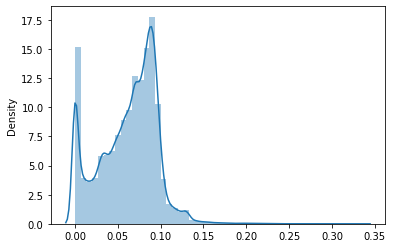

In [31]:
predict = np.array(all_predictions)
predict = np.where(predict<0, 0.0, predict)
sns.distplot(pd.DataFrame({'ans':predict}))

In [37]:
submission['PM2.5'] = predict
submission.to_csv(os.path.join('/opt/ml/submission_pm', f'{model_name}.csv'), index=False, encoding="utf-8")
print('test inference is done!')

test inference is done!
